# Project ECE 273 Topic 3

## Polynomial Neural Networks and Low Rank Matrix Factorization 

##### Goal of the project

The goal of this project is to understand recovery of a low rank matrix from a specifically constrained set of data measurements. In [1] a neural network with a specific underlying data model is shown to be recovered using a non convex iterative algorithm. In [2], a convex relaxation to solve a similar convex problem which can recover a specific rank r matrix with high probability using constrained minimization is shown. This project helps us understand how it is possible to solve a highly non convex problem using an iterative algorithm, which recovers a matrix with high probability given that the data has a specific format. We also learn to understand how to to relax a non convex problem into a convex one which is solvable with computational solvers. Additionally, we learn to understand the preconditions on the data which need to be fulfilled for a system like this to perform well.

##### Background  and  motivation:  You  should  cite  relevant  references,  explain  why  the  problem  is  important, and its applications. You should also cite the datasets being used.

Many problems in our world can be represented as a suitable matrix. For example, we can represent a low degree statistical model for a random process or a low order controller for a plant as a low rank matrix [11,12]. However, in real life, we never obtain 100% of information and thus always have a limited amount of data. But this data is often meaningful, if we are able to extract relevant patterns from it. Estimating or completing low rank matrices from a given dataset is thus helpful for us to understand data, even though we can only obtain a limited amount of it [1, 3]. 

We can make use of this problem for several applications. One is signal reconstruction [2], where the authors show that they can reconstruct a matrix from a bounded number of noisy measurements per degree of freedom using different versions of minimization problems [2]. A recovering method like this can also be used for face recognition [5,7], Quantum state tomography [6] and distance measurements [2]. Matrix sensing and completion has also been used for control and system identification [9] as well as collaborative filtering [10]. Soltani and Hegde found a way to provably recover learning parameters using low rank matrix estimation for learning a neural network of a specific form which learns a specific data distribution [1]. Because of the broad applicability of low-rank matrices this topic is important to a broad community of data scientists and mathematicians, as well as companies (among others used for the famous million dollar Netflix challenge). 

Using heuristic non convex iterative algorithms like in [1] to solve low rank estimation problems can be helpful with respect to runtime. Even though convex solutions offer an optimal solution, it can require exponential running time [3]. Thus, an iterative algorithm which recovers a low rank matrix can be helpful in real life, where we have limited computing time and power. 

##### Results:  Include  all  figures;  you  can  also  use  tables  to  present  your  results,  especially  for  comparing multiple algorithms

##### Read the references and explain why solving the problem (1) is equal to training the corresponded network? 

We see in 1 that we minimize empirical risk, which is the average loss of misprediction between the true label and the preduction by the mapping $$y_i - x_i^TLx_i$$ with the activation function $$\phi(z) = z^2$$ and the constraint that $$ rank(L) \leq r$$

Solving problem 1 is equal to the corresponding network because L* mapping between the data ($x_i$) and the label ($y_i$) and represents the weights of the hidden and output layer of the respective network. Because of the assumptions of the relationship of $x$ and $y$ with $L_*$ we can minimize equation (1) under the assumption that $rank(L) \leq r$.

##### Why is it not a convex optimization problem? 

It is not a convex optimization problem because the empirical risk contains fourth-powers for the entries of the weights $w_j$ and squares of $a_j$ (which can be obtained by eigendecomposition of $L$) [1].

##### Why is problem (3) a suitable convex relaxation for problem (2)?

[3] shows that minimizing the nuclear norm heuristic under the restricted isometry property leads to the minimum solution. So if we minimize the nuclear norm of $L$ we get a minimum solution of the problem. If we now analyse the constraint that the the largest singular value of the estimation of $A^*(e)$, which is the estimation of $L$ weighted with the misprediction error for each data sample, is smaller than some constant $\lambda$. It is a suitable convex relaxation because it recovers $L$ with a limited error and thus we can reconstruct $y$ in (2) with the $L$ obtained in (3).

##### Method/Techniques

The methods in this project are two fold. On the one hand, we have a non convex learning algorithm which provides an understandable recovery of a matrix. There are different versions available with different computational efficiencies [1]. We use the less computational efficient method, but whose interpretation is intuitive. This method estimates a matrix L by iterating through the average of the dot product of the data features in batches and multiplying it with the difference of the prediction with the real label (error term). This error lerm uses the current L_t matrix to preduct from the data samples and compares it with the actual ground truth label. This kind of resembles a loss function which is regularly used in learning neural networks. The new 'weights' matrix L_t is then updated by the projection onto the subspace of all rank r matrices of the difference of L_t-1 with this average and a weighted bias term, which is novel in the work provided by [1]. The bias term is the error of the current prediction minus 0.5 the average ground truth value. Instead of using an error threshold this paper uses a fixed iteration constant. 

On the other hand, we have a convex relaxation of the problem which can be expressed in different ways [2]. The broad idea of the convex relaxation is that we want to minimize the nuclear norm of our variable matrix L under the conditions that the operator norm (largest singular value) of the adjoint operator of the difference between the prediction and the estimation is smaller or equal to a constant lambda. How to choose the constant lambda has been explored in [2] I.4 where, lambda has a special structure which is proved to perform well for a given convex minimization problem. 

In [1]:
import numpy as np
import cvxpy as cp
from sklearn.decomposition import PCA
from numpy import linalg as la
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.utils.validation import check_symmetric
from sklearn.datasets import make_spd_matrix
from tensorflow.keras.datasets import mnist
import matlab.engine
import io
from IPython.core.magic import register_cell_magic
from sklearn.decomposition import PCA

In [2]:
def test_symmetry(square):
    check_symmetric(square, tol=1e-10, raise_exception=False)
    return True

def relative_error(L_star_norm, L_hat_norm):
    rel_err = np.abs((L_star_norm - L_hat_norm)/L_star_norm)
    return rel_err

def create_L_star(p, r, cov=100, mean = 100):
    U = np.random.normal(0,cov,(p, r))
    L_star = np.dot(U, U.T)
    assert(L_star.shape == (p,p))
    assert(test_symmetry(L_star))
    return np.array(L_star)

def create_y(x, L_star):
    x = np.array(x)
    y = list(map(lambda x_i: np.array(np.dot(np.dot(x_i.T,L_star), x_i)), x))
    return np.array(y)

def check(matrix):
    assert(not (np.isnan(matrix).any() or np.isinf(matrix).any()))
    assert(test_symmetry(matrix))
    

##### Generate  a  random  data  set from  a  normal  distribution  (you  can  choose  the  mean  and  the covariance),  and  one  ground  truth  network  (Based  on  the  given  architecture  in  [1])  which  generates the output yi corresponding to the input xi. 

In [3]:
m = 8000
p = 10
r = 5
K = 20

mean = np.zeros(p)
cov = np.identity(p)
x = np.array(np.random.multivariate_normal(mean,cov,(K+1)*m))
print('Dataset of size:', x.shape)
x = x.reshape(x.shape[0], x.shape[1], 1)

L_star = create_L_star(p,r)
assert(test_symmetry(L_star))
print('L_star is a matrix with rank', la.matrix_rank(L_star, hermitian = True))
y = create_y(x, L_star)

Dataset of size: (168000, 10)
L_star is a matrix with rank 5


##### Implement Algorithm 1 in [1] and test it on the data set you have generated.

In [4]:
def g(x,y,L,const, bias_term):
    sum_arr = np.zeros(L.shape)
    xTLx = np.array(list(map(lambda x_i: np.dot(np.dot(x_i.T, L), x_i), x)))
    assert(x[0].shape[0] == x[0].T.shape[1])
    xxT = np.array(list(map(lambda x_i: np.dot(x_i,x_i.T), x)))
    xTLxy = xTLx - y
    check(xxT[0])
    inner = xTLxy * xxT
    check(inner[0])
    inner = np.array(list(map(lambda x_i_inner: x_i_inner, inner)))
    result = const * np.sum(inner, axis=0)
    return result

def A(L,x):
    assert(L.shape[1] == L.shape[0] and x[0].shape[0] == L.shape[0])
    x = np.array(x)
    A_Lt = list(map(lambda x_i: np.dot(np.dot(x_i.T,L), x_i), x ))
    A_Lt = np.array(A_Lt)
    assert(A_Lt.shape[0] == x.shape[0])
    A_Lt = np.array(A_Lt)
    A_Lt = A_Lt.reshape(A_Lt.shape[0], 1)
    return A_Lt

def bias(x, L_t, const, y_bar):
    A_Lt = A(L_t,x)
    one = np.ones((A_Lt.shape[0], 1))
    assert(one.T.shape[0] == A_Lt.shape[1])
    a_term = (const * (np.sum(A_Lt)))
    a_term = a_term.flatten()[0]
    bias_term = (a_term - 0.5 * y_bar) * np.identity(L_t.shape[0])
    check(bias_term)
    return bias_term

In [5]:
def EP_ROM(y, K, x, r, p):
    L_t = np.zeros((p,p))
    all_batches = x.shape[0]
    m = int(all_batches/(K+1))
    for t in range(0,K+1):
        const = (1/(2*m))
        start = t*m
        end = (t+1)*m
        x_t = x[start:end,:]
        y_t = y[start:end]
        y_bar = np.mean(y_t)
        
        bias_term = bias(x_t, L_t, const, y_bar)
        g_Lt = g(x_t,y_t,L_t, const, bias_term)
        
        check(L_t)
        check(g_Lt)
        check(bias_term)
        
        inner_projection = L_t - (g_Lt - bias_term)
        check(inner_projection)
        
        U, s, VT = la.svd(inner_projection)
        s = np.concatenate((s[0:r], np.zeros(p-r)))
        Sigma = np.diag(s)
        L_t = U.dot(Sigma.dot(VT))
        
        check(L_t)
    return L_t

In [6]:
print(y.shape)
L_hat = EP_ROM(y, K, x, r, p)  
L_hat_norm = la.norm(L_hat, ord = 2)
L_star_norm = la.norm(L_star, ord = 2)
assert(test_symmetry(L_star))
print('L* matrix with rank', la.matrix_rank(L_star, hermitian = True))
rel_err = relative_error(L_star_norm, L_hat_norm)
print('m:', m, 'p:', p,'K:', K, 'r:', r, 'err:', rel_err, 'L* recovered?', rel_err < 0.05)
assert(test_symmetry(L_hat))

(168000, 1, 1)
L* matrix with rank 5
m: 8000 p: 10 K: 20 r: 5 err: 4.0421220346427464e-16 L* recovered? True


##### Try data sets with different sizes and different initialization. Can you recover the ground truth L* (or equivalently, the network)? 

In [94]:
m = 1000
p = 10
r = 5
K = 1
mean = np.zeros(p)
cov = np.identity(p)
x = np.array(np.random.multivariate_normal(mean,cov,K*m))
print('Dataset of size:', x.shape)
x = x.reshape(x.shape[0], x.shape[1], 1)
L_star = create_L_star(p,r)
assert(test_symmetry(L_star))
print('L* matrix with rank', la.matrix_rank(L_star, hermitian = True))
y = create_y(x, L_star)


L_hat = EP_ROM(y, K, x, r, p)  
L_hat_norm = la.norm(L_hat, ord = 2)
L_star_norm = la.norm(L_star, ord = 2)
assert(test_symmetry(L_star))
rel_err = relative_error(L_star_norm, L_hat_norm)
print('m:', m, 'p:', p,'K:', K, 'r:', r, 'err:', rel_err, 'L* recovered?', rel_err < 0.05)
assert(test_symmetry(L_hat))

Dataset of size: (1000, 10)
L* matrix with rank 5
m: 1000 p: 10 K: 1 r: 5 err: 0.01649500303863963 L* recovered? True


In [99]:
m = 8000
p = 10
r = 5
K = 30
mean = np.ones(p)
cov = make_spd_matrix(p)
x = np.array(np.random.multivariate_normal(mean=mean,cov=cov,size=K*m))
print('Dataset of size:', x.shape)
x = x.reshape(x.shape[0], x.shape[1], 1)
L_star = create_L_star(p,r)
assert(test_symmetry(L_star))
print('L* matrix with rank', la.matrix_rank(L_star, hermitian = True))
y = create_y(x, L_star)

Dataset of size: (240000, 10)
L* matrix with rank 5


In [100]:
L_hat = EP_ROM(y, K, x, r, p)  
L_hat_norm = la.norm(L_hat, ord = 2)
L_star_norm = la.norm(L_star, ord = 2)
assert(test_symmetry(L_star))
rel_err = relative_error(L_star_norm, L_hat_norm)
print('m:', m, 'p:', p,'K:', K, 'r:', r, 'err:', rel_err, 'L* recovered?', rel_err < 0.05)
assert(test_symmetry(L_hat))

m: 8000 p: 10 K: 30 r: 5 err: 3.592271437386146e+74 L* recovered? False


In [109]:
m = 1000
p = 10
r = 5
K = [1, 3, 5, 10, 20, 30, 40]
mean = np.zeros(p)
cov = np.identity(p)
err = []
for k in K:
    x = np.array(np.random.multivariate_normal(mean,cov,k*m))
    print('Dataset of size:', x.shape)
    x = x.reshape(x.shape[0], x.shape[1], 1)
    L_star = create_L_star(p,r)
    assert(test_symmetry(L_star))
    print('L* matrix with rank', la.matrix_rank(L_star, hermitian = True))
    y = create_y(x, L_star)

    
    L_hat = EP_ROM(y, k, x, r, p)  
    L_hat_norm = la.norm(L_hat, ord = 2)
    L_star_norm = la.norm(L_star, ord = 2)
    assert(test_symmetry(L_star))
    rel_err = relative_error(L_star_norm, L_hat_norm)
    err.append(rel_err)
    print('m:', m, 'p:', p,'K:', k, 'r:', r, 'err:', rel_err, 'L* recovered?', rel_err < 0.05)
    assert(test_symmetry(L_hat))

Dataset of size: (1000, 10)
L* matrix with rank 5
m: 1000 p: 10 K: 1 r: 5 err: 0.04169654859446736 L* recovered? True
Dataset of size: (3000, 10)
L* matrix with rank 5
m: 1000 p: 10 K: 3 r: 5 err: 0.002031869026572138 L* recovered? True
Dataset of size: (5000, 10)
L* matrix with rank 5
m: 1000 p: 10 K: 5 r: 5 err: 0.00017188791760909823 L* recovered? True
Dataset of size: (10000, 10)
L* matrix with rank 5
m: 1000 p: 10 K: 10 r: 5 err: 3.2698608558398875e-07 L* recovered? True
Dataset of size: (20000, 10)
L* matrix with rank 5
m: 1000 p: 10 K: 20 r: 5 err: 2.4031001928117284e-12 L* recovered? True
Dataset of size: (30000, 10)
L* matrix with rank 5
m: 1000 p: 10 K: 30 r: 5 err: 4.514650012725903e-16 L* recovered? True
Dataset of size: (40000, 10)
L* matrix with rank 5
m: 1000 p: 10 K: 40 r: 5 err: 1.1135881253521228e-16 L* recovered? True


Relative error with respect to number of iterations for EP_ROM.


Text(0, 0.5, 'Relative Error')

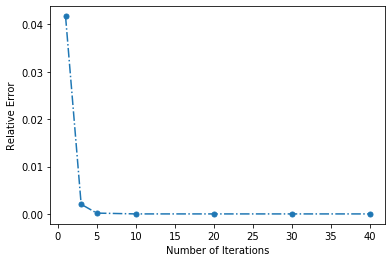

In [110]:
x = K
y = err
print('Relative error with respect to number of iterations for EP_ROM.')
plt.plot(x,y, linestyle = '-.', marker='o',markersize=5)

plt.xlabel('Number of Iterations')
plt.ylabel('Relative Error')

##### Plot the probability of success by varying the values of m, p and r,  as  well  as  different  initializations  (you  can  refer  to  [1]  for  some  representative  plots).  

I use 20 Monte Carlo trials to establish the empirical probability
of success. Success is when the relative error between L_hat (the estimate of L_star) and the ground truth L_star (measured in terms of spectral norm) is less than 0.05.
In this trial there is no additive noise. This setup is similar to [1] but with less monte carlo trials, because my CPU unfortunately couldn't handle more in the limited amount of time I had for this project.

In [5]:
all_m = [1000, 3000, 6000]
all_p = [100, 50, 20]
all_r = [10, 5]
all_var_L = [0.1, 1, 10]
K = 20

def getSuccessRates(all_m, all_p, all_r, convex, K=20):
    success_rate_df = pd.DataFrame(columns=['m','p','r', 'var_L', 'success_rate'])
    for p in all_p:
        mean = np.zeros(p)
        cov = np.identity(p)
        for r in all_r:
            for var_L in all_var_L:
                for m in all_m:
                    success = 0
                    failure = 0
                    for i in range(1,20):
                        x = np.array(np.random.multivariate_normal(mean,cov,K*m))
                        if not convex:
                            x = x.reshape(x.shape[0], x.shape[1], 1)
                        L_star = create_L_star(p,r, var_L)
                        L_star_norm = la.norm(L_star, ord = 2)
                        y = create_y(x, L_star)
                        if convex:
                            L_hat = solveConvexProblem(1, x, y, p)
                        else:
                            L_hat = EP_ROM(y, K, x, r, p)
                        L_hat_norm = la.norm(L_hat, ord = 2)
                        rel_err = relative_error(L_star_norm, L_hat_norm)
                        if rel_err < 0.05:
                            success =+ 1
                        else:
                            failure =+ 1
                    print("success rate for p:",p, 'r:', r,'m:',m, 'var_L:', var_L, success / (success + failure))
                    new_row = {'m': m, 'p': p, 'r': r, 'var_L': var_L, 'success_rate': success / (success + failure)}
                    success_rate_df = success_rate_df.append(new_row, ignore_index=True)
    return success_rate_df
    

In [20]:
success_rate_df = getSuccessRates(all_m, all_p, all_r, False, K)
success_rate_df['p']

success rate for p: 100 r: 10 m: 1000 0.0
success rate for p: 100 r: 10 m: 3000 0.0
success rate for p: 100 r: 10 m: 6000 1.0
success rate for p: 100 r: 10 m: 1000 0.0
success rate for p: 100 r: 10 m: 3000 0.0
success rate for p: 100 r: 10 m: 6000 1.0
success rate for p: 100 r: 10 m: 1000 0.0
success rate for p: 100 r: 10 m: 3000 0.0
success rate for p: 100 r: 10 m: 6000 1.0
success rate for p: 100 r: 5 m: 1000 0.0
success rate for p: 100 r: 5 m: 3000 1.0
success rate for p: 100 r: 5 m: 6000 1.0
success rate for p: 100 r: 5 m: 1000 0.0
success rate for p: 100 r: 5 m: 3000 1.0
success rate for p: 100 r: 5 m: 6000 1.0
success rate for p: 100 r: 5 m: 1000 0.0
success rate for p: 100 r: 5 m: 3000 1.0
success rate for p: 100 r: 5 m: 6000 1.0
success rate for p: 50 r: 10 m: 1000 0.0
success rate for p: 50 r: 10 m: 3000 1.0
success rate for p: 50 r: 10 m: 6000 1.0
success rate for p: 50 r: 10 m: 1000 0.0
success rate for p: 50 r: 10 m: 3000 1.0
success rate for p: 50 r: 10 m: 6000 1.0
success

0     100.0
1     100.0
2     100.0
3     100.0
4     100.0
5     100.0
6     100.0
7     100.0
8     100.0
9     100.0
10    100.0
11    100.0
12    100.0
13    100.0
14    100.0
15    100.0
16    100.0
17    100.0
18     50.0
19     50.0
20     50.0
21     50.0
22     50.0
23     50.0
24     50.0
25     50.0
26     50.0
27     50.0
28     50.0
29     50.0
30     50.0
31     50.0
32     50.0
33     50.0
34     50.0
35     50.0
36     20.0
37     20.0
38     20.0
39     20.0
40     20.0
41     20.0
42     20.0
43     20.0
44     20.0
45     20.0
46     20.0
47     20.0
48     20.0
49     20.0
50     20.0
51     20.0
52     20.0
53     20.0
Name: p, dtype: float64

Influence of the parameter p dimension of training data, L* and approximation of L* with respect to batch size m.


Text(0, 0.5, 'Probability of success')

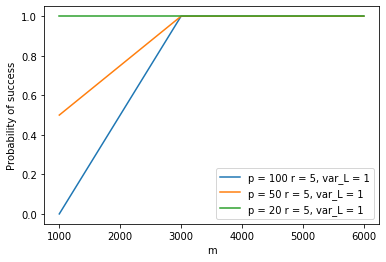

In [97]:
plt.figure()

p_plot = success_rate_df[success_rate_df['p'] == 100]
p_plot = p_plot[p_plot['r'] == 5]
p_plot = p_plot[p_plot['var_L'] == 1]

x = p_plot['m']
y = p_plot['success_rate']
plt.plot(x,y)

p_plot = success_rate_df[success_rate_df['p'] == 50]
p_plot = p_plot[p_plot['r'] == 5]
p_plot = p_plot[p_plot['var_L'] == 1]

x = p_plot['m']
y = p_plot['success_rate']
plt.plot(x,y)

p_plot = success_rate_df[success_rate_df['p'] == 20]
p_plot = p_plot[p_plot['r'] == 5]
p_plot = p_plot[p_plot['var_L'] == 1]

x = p_plot['m']
y = p_plot['success_rate']
plt.plot(x,y)
print('Influence of the parameter p dimension of training data, L* and approximation of L* with respect to batch size m.')

plt.legend(["p = 100 r = 5, var_L = 1", "p = 50 r = 5, var_L = 1", "p = 20 r = 5, var_L = 1"])
plt.xlabel('m')
plt.ylabel('Probability of success')



Influence of the rank of L* and approximation of L* with respect to batch size m.


Text(0, 0.5, 'Probability of success')

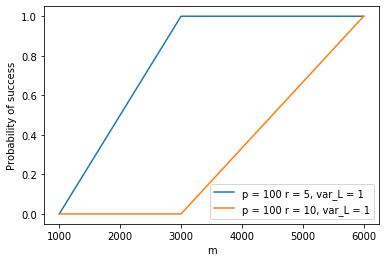

In [89]:
plt.figure()

p_plot = success_rate_df[success_rate_df['p'] == 100]
p_plot = p_plot[p_plot['r'] == 5]
p_plot = p_plot[p_plot['var_L'] == 1]

x = p_plot['m']
y = p_plot['success_rate']
plt.plot(x,y)

p_plot = success_rate_df[success_rate_df['p'] == 100]
p_plot = p_plot[p_plot['r'] == 10]
p_plot = p_plot[p_plot['var_L'] == 1]

x = p_plot['m']
y = p_plot['success_rate']
plt.plot(x,y)

print('Influence of the rank of L* and approximation of L* with respect to batch size m.')
plt.legend(["p = 100 r = 5, var_L = 1", "p = 100 r = 10, var_L = 1", "p = 20 r = 5, var_L = 1"])
plt.xlabel('m')
plt.ylabel('Probability of success')

Influence of the initialisation variance on the results with respect to batch size m.


Text(0, 0.5, 'Probability of success')

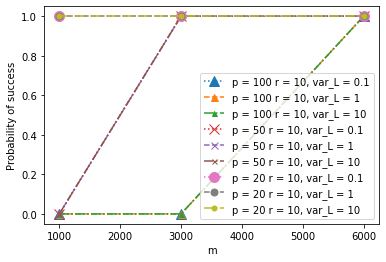

In [98]:
plt.figure()

p_plot = success_rate_df[success_rate_df['p'] == 100]
p_plot = p_plot[p_plot['r'] == 10]
p_plot = p_plot[p_plot['var_L'] == 0.1]

x = p_plot['m']
y = p_plot['success_rate']
plt.plot(x,y, linestyle = ':', marker='^',markersize=10)

p_plot = success_rate_df[success_rate_df['p'] == 100]
p_plot = p_plot[p_plot['r'] == 10]
p_plot = p_plot[p_plot['var_L'] == 1]

x = p_plot['m']
y = p_plot['success_rate']
plt.plot(x,y, linestyle = '--', marker='^',markersize=7)

p_plot = success_rate_df[success_rate_df['p'] == 100]
p_plot = p_plot[p_plot['r'] == 10]
p_plot = p_plot[p_plot['var_L'] == 10]

x = p_plot['m']
y = p_plot['success_rate']
plt.plot(x,y, linestyle = '-.', marker='^',markersize=5)


p_plot = success_rate_df[success_rate_df['p'] == 50]
p_plot = p_plot[p_plot['r'] == 10]
p_plot = p_plot[p_plot['var_L'] == 0.1]

x = p_plot['m']
y = p_plot['success_rate']
plt.plot(x,y, linestyle = ':', marker='x',markersize=10)

p_plot = success_rate_df[success_rate_df['p'] == 50]
p_plot = p_plot[p_plot['r'] == 10]
p_plot = p_plot[p_plot['var_L'] == 1]

x = p_plot['m']
y = p_plot['success_rate']
plt.plot(x,y, linestyle = '--', marker='x',markersize=7)

p_plot = success_rate_df[success_rate_df['p'] == 50]
p_plot = p_plot[p_plot['r'] == 10]
p_plot = p_plot[p_plot['var_L'] == 10]

x = p_plot['m']
y = p_plot['success_rate']
plt.plot(x,y, linestyle = '-.', marker='x',markersize=5)

p_plot = success_rate_df[success_rate_df['p'] == 20]
p_plot = p_plot[p_plot['r'] == 10]
p_plot = p_plot[p_plot['var_L'] == 0.1]

x = p_plot['m']
y = p_plot['success_rate']
plt.plot(x,y, linestyle = ':', marker='o',markersize=10)

p_plot = success_rate_df[success_rate_df['p'] == 20]
p_plot = p_plot[p_plot['r'] == 10]
p_plot = p_plot[p_plot['var_L'] == 1]

x = p_plot['m']
y = p_plot['success_rate']
plt.plot(x,y, linestyle = '--', marker='o',markersize=7)

p_plot = success_rate_df[success_rate_df['p'] == 20]
p_plot = p_plot[p_plot['r'] == 10]
p_plot = p_plot[p_plot['var_L'] == 10]

x = p_plot['m']
y = p_plot['success_rate']
print('Influence of the initialisation variance on the results with respect to batch size m.')
plt.plot(x,y, linestyle = '-.', marker='o',markersize=5)


plt.legend(["p = 100 r = 10, var_L = 0.1", "p = 100 r = 10, var_L = 1", "p = 100 r = 10, var_L = 10", "p = 50 r = 10, var_L = 0.1", "p = 50 r = 10, var_L = 1", "p = 50 r = 10, var_L = 10", "p = 20 r = 10, var_L = 0.1", "p = 20 r = 10, var_L = 1", "p = 20 r = 10, var_L = 10"])
plt.xlabel('m')
plt.ylabel('Probability of success')

##### Comment  on your results. 

As we can see, the algorithm is not able to recover data which is not distributed from a normal distribution with zero mean and identity covariance. This makes sense because the authors in [1] explicitly assumed that their training data is distributed with zero mean and identity covariance. With respect to the parameters, we can see that the parameter p influences the results and probability of success. We can see that the probability of success increases with lower $p$ for smaller batch size $m$. For larger batch sizes, the parameter $p$ does not influence the probability of success so much. We can see that the initialization variance of the ground truth matrix $L_*$ does not influence the results at all. We can see that the parameter $r$ influences the outcome of the experiment, a lower r produces better results.

##### Add noise to the measurements and try different noise powers. 

In [107]:
all_m = [3000, 8000]
p = 100
r = 5
var = 1
K = 20
noise_levels = [0.0001, 0.1, 1, 10, 100]
mean = np.zeros(p)
cov = np.identity(p)
for m in all_m:
    x = np.array(np.random.multivariate_normal(mean,cov,K*m))
    x = x.reshape(x.shape[0], x.shape[1], 1)
    L_star = create_L_star(p,r)
    test_symmetry(L_star)
    y = create_y(x, L_star)
    for noise_level in noise_levels:
        noise = np.random.normal(0, noise_level,(K*m, p))
        noise = noise.reshape(noise.shape[0], noise.shape[1], 1)
        x_noise = x + noise
        L_hat = EP_ROM(y, K, x_noise, r, p)  
        L_hat_norm = la.norm(L_hat, ord = 2)
        L_star_norm = la.norm(L_star, ord = 2)
        rel_err = relative_error(L_star_norm, L_hat_norm)
        print('m', m, 'noise level:', noise_level, 'm:', m,'p:',p, 'var:',var,'err:', rel_err, 'Successful recovery?', rel_err < 0.05)

m 3000 noise level: 0.0001 m: 3000 p: 100 var: 1 err: 2.8777891831608596e-06 Successful recovery? True
m 3000 noise level: 0.1 m: 3000 p: 100 var: 1 err: 0.027195618417835243 Successful recovery? True
m 3000 noise level: 1 m: 3000 p: 100 var: 1 err: 8.976027773945851e+20 Successful recovery? False
m 3000 noise level: 10 m: 3000 p: 100 var: 1 err: 4.461560245450308e+94 Successful recovery? False
m 3000 noise level: 100 m: 3000 p: 100 var: 1 err: 3.290100206090703e+176 Successful recovery? False
m 8000 noise level: 0.0001 m: 8000 p: 100 var: 1 err: 2.201194356318444e-06 Successful recovery? True
m 8000 noise level: 0.1 m: 8000 p: 100 var: 1 err: 0.01920486541477712 Successful recovery? True
m 8000 noise level: 1 m: 8000 p: 100 var: 1 err: 3.606879607918283e+19 Successful recovery? False
m 8000 noise level: 10 m: 8000 p: 100 var: 1 err: 6.6883444965052e+93 Successful recovery? False
m 8000 noise level: 100 m: 8000 p: 100 var: 1 err: 4.999101461688042e+175 Successful recovery? False


##### Report where the algorithm fails and succeeds.

We can see that the noise levels influence the error immensely. If the noise variance is below 1, we are still able to learn the network. However, if the noise levels are above 1, the error explodes and we are not able to learn the network anymore. This is independent of the batch size m.

All in all, the algorithm succeeds if we have a low noise level (noise constructed from a normal distribution with mean 0 and variance <1) and we have enough training data. The algorithm performs better if we have a lower rank matrix to reconstruct. The algorithm is robust to different initialisations of $L_*$, but is limited to training data distributed from a normal distribution with mean 0 and identity covariance. It is also limited because the labels $y$ have to correspond to a ground truth of $x^TL_*x$. The algorithm itself is able to learn the ground truth pretty quickly, as the error reduces quickly with increasing number of iterations.

##### Formulate  the  problem  of  training  neural  network  (or  equivalently,  finding L*)  as  a  convex  problem, based on [2] and [3]. 


In [16]:
def A_star_cvx(x,e):
    assert(x.shape[0] == e.shape[0])
    adjoint_value = np.zeros((x.shape[1], x.shape[1]))
    for i in range(0, x.shape[0]):
        x_i = x[i]
        e_i = e[i]
        x_i = np.array(x_i)
        x_i = x_i.reshape(x_i.shape[0], 1)
        xxt = np.dot(x_i, x_i.T)
        exxt = cp.multiply(e_i, xxt)
        adjoint_value = np.sum([adjoint_value, exxt], axis=0)
    return adjoint_value

def A_star_cvx_faster(x,e):
    assert(x.shape[0] == e.shape[0])
    x = x.reshape(x.shape[0], x.shape[1], 1)
    e = e.reshape(e.shape[0], 1, 1)
    xxt = np.array(list(map( lambda x_i: np.dot(x_i, x_i.T), x)))
    exxt = e * xxt
    exxtmap = list(map(lambda x: x[0][0][0][0], exxt))
    print(exxt[0][0].shape)
    adjoint_value = np.sum(exxt, axis=0)
    print(x.shape, e.shape, xxt.shape, exxt.shape,adjoint_value.shape,adjoint_value[0,0][0][0].shape)
    return adjoint_value

def A_cvx_faster(L,x):
    x = x.reshape(x.shape[0], x.shape[1], 1)
    x = np.array(x)
    A_Lt = []
    assert(L.shape == (x.shape[1], x.shape[1]) and L[0,0].shape == ())
    A_Lt = list(map(lambda x_i: cp.quad_form(x_i, L), x))
    return np.array(A_Lt)


def A_cvx(L,x):
    x = x.reshape(x.shape[0], x.shape[1], 1)
    A_Lt = []
    assert(L.shape == (x.shape[1], x.shape[1]) and L[0,0].shape == ())
    for i in range(x.shape[0]):
        x_i = x[i]
        A_Lt.append(cp.quad_form(x_i, L))
    return np.array(A_Lt)

##### Use the data set you generated in the last part and solve this convex problem with CVX/CVXPY library. You may need to tune λ by trying different values and cross validating against the training  dataset  (Read  [2]  for  suitable  ways  to  choose λ).  

In [7]:
def solveConvexProblem(offset, x, y, p,var=1):
    C_0 = 4*np.sqrt((1+np.sqrt(2)-1)* np.log(12)) + offset
    lmbd = lambda variance : C_0 * np.sqrt(p*variance)
    
    L = cp.Variable((p,p))
    objective = cp.Minimize(cp.norm(L, "nuc"))
    A_L = A_cvx_faster(L,x)
    assert(y.shape[0] ==  A_L.shape[0])
    A_L = A_L.reshape(A_L.shape[0], 1)
    error = y - A_L
    error = error.reshape(error.shape[0], )
    assert(error.shape == (x.shape[0], ))
    a_st_x_e = A_star_cvx(x, error)
    constraints = [cp.norm(a_st_x_e, 2) <= lmbd(np.sqrt(var))]
    prob = cp.Problem(objective, constraints)

    result = prob.solve()
    L_hat = L.value
    return L_hat

In [79]:
m = 1000
p = 10
r = 5
K = 1
var = 1
offset = 1

mean = np.zeros(p)
cov = np.identity(p)
x = np.array(np.random.multivariate_normal(mean,cov,K*m))
x = x.reshape(x.shape[0], x.shape[1], 1)
L_star = create_L_star(p,r)
y = np.array(create_y(x, L_star))
y = y.reshape(y.shape[0], 1, 1)
y = y.reshape(y.shape[0], 1)
print('data created')
L_hat = solveConvexProblem(offset, x, y, p)
L_hat_norm = la.norm(L_hat, ord = 2)
L_star_norm = la.norm(L_star, ord = 2)
rel_err = np.abs((L_star_norm - L_hat_norm)/L_star_norm)
print('error:', rel_err, 'Error < 0.05?', rel_err < 0.05)

data created
error: 1.3739564991953064e-08 Error < 0.05? True


##### Compare  your  result  with  previous  solutions and plots, including the need for initialization. 

In [11]:
m = 4000
p = 10
r = 5
offset = 1
mean = np.ones(p)
cov = make_spd_matrix(p)
x = np.array(np.random.multivariate_normal(mean=mean,cov=cov,size=m))
print('Dataset of size:', x.shape)
x = x.reshape(x.shape[0], x.shape[1], 1)
L_star = create_L_star(p,r)
assert(test_symmetry(L_star))
print('L* matrix with rank', la.matrix_rank(L_star, hermitian = True))
y = create_y(x, L_star)
y = y.reshape(y.shape[0], 1, 1)
y = y.reshape(y.shape[0], 1)
L_hat = solveConvexProblem(offset, x, y, p)
L_hat_norm = la.norm(L_hat, ord = 2)
L_star_norm = la.norm(L_star, ord = 2)
assert(test_symmetry(L_star))
rel_err = relative_error(L_star_norm, L_hat_norm)
print('m:', m, 'p:', p,'K:', K, 'r:', r, 'err:', rel_err, 'L* recovered?', rel_err < 0.05)
assert(test_symmetry(L_hat))

Dataset of size: (4000, 10)
L* matrix with rank 5
m: 4000 p: 10 K: 20 r: 5 err: 1.843186168141248e-05 L* recovered? True


/Users/jessicaechterhoff/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:855: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


In [9]:
offset = 1
all_m = [1000, 3000, 6000]
all_p = [5, 10, 30]
all_var_L = [0.1, 1, 10]

success_rate_df = pd.DataFrame(columns=['m','p', 'var_L', 'rel_err'])

for p in all_p:
    mean = np.zeros(p)
    cov = np.identity(p)
    for var_L in all_var_L:
        for m in all_m:
            x = np.array(np.random.multivariate_normal(mean,cov,m))
            x = x.reshape(x.shape[0], x.shape[1], 1)
            L_star = np.array(create_L_star(p,r,var_L))
            y = np.array(create_y(x, L_star))
            y = y.reshape(y.shape[0], 1, 1)
            y = y.reshape(y.shape[0], 1)
            L_hat = solveConvexProblem(offset, x, y, p)
            L_hat_norm = la.norm(L_hat, ord = 2)
            L_star_norm = la.norm(L_star, ord = 2)
            rel_err = np.abs((L_star_norm - L_hat_norm)/L_star_norm)
            print('m', m, 'p', p, 'var_L', var_L, 'error:', rel_err, 'Error < 0.05?', rel_err < 0.05)
            new_row = {'m': m, 'p': p, 'var_L': var_L, 'error': rel_err}
            success_rate_df = success_rate_df.append(new_row, ignore_index=True)
                
            

m 1000 p 5 var_L 0.1 error: 0.007447434250887569 Error < 0.05? True
m 3000 p 5 var_L 0.1 error: 0.0023337839994942455 Error < 0.05? True
m 6000 p 5 var_L 0.1 error: 8.841693223573169e-05 Error < 0.05? True
m 1000 p 5 var_L 1 error: 0.00042943835396207594 Error < 0.05? True
m 3000 p 5 var_L 1 error: 4.3861267353239115e-05 Error < 0.05? True
m 6000 p 5 var_L 1 error: 1.5045667634360655e-06 Error < 0.05? True
m 1000 p 5 var_L 10 error: 1.9908313370672016e-06 Error < 0.05? True
m 3000 p 5 var_L 10 error: 2.8068750466235463e-06 Error < 0.05? True
m 6000 p 5 var_L 10 error: 3.493725932591566e-07 Error < 0.05? True
m 1000 p 10 var_L 0.1 error: 0.07945231453243637 Error < 0.05? False
m 3000 p 10 var_L 0.1 error: 0.008664034168580925 Error < 0.05? True
m 6000 p 10 var_L 0.1 error: 0.00021719302465860504 Error < 0.05? True
m 1000 p 10 var_L 1 error: 0.0006700222768279488 Error < 0.05? True
m 3000 p 10 var_L 1 error: 0.00031721936885699604 Error < 0.05? True
m 6000 p 10 var_L 1 error: 1.481850964

In [10]:
print(success_rate_df)

         m     p  var_L  rel_err         error
0   1000.0   5.0    0.1      NaN  7.447434e-03
1   3000.0   5.0    0.1      NaN  2.333784e-03
2   6000.0   5.0    0.1      NaN  8.841693e-05
3   1000.0   5.0    1.0      NaN  4.294384e-04
4   3000.0   5.0    1.0      NaN  4.386127e-05
5   6000.0   5.0    1.0      NaN  1.504567e-06
6   1000.0   5.0   10.0      NaN  1.990831e-06
7   3000.0   5.0   10.0      NaN  2.806875e-06
8   6000.0   5.0   10.0      NaN  3.493726e-07
9   1000.0  10.0    0.1      NaN  7.945231e-02
10  3000.0  10.0    0.1      NaN  8.664034e-03
11  6000.0  10.0    0.1      NaN  2.171930e-04
12  1000.0  10.0    1.0      NaN  6.700223e-04
13  3000.0  10.0    1.0      NaN  3.172194e-04
14  6000.0  10.0    1.0      NaN  1.481851e-05
15  1000.0  10.0   10.0      NaN  1.749925e-06
16  3000.0  10.0   10.0      NaN  4.201353e-08
17  6000.0  10.0   10.0      NaN  1.160878e-06
18  1000.0  30.0    0.1      NaN  2.696378e-02
19  3000.0  30.0    0.1      NaN  1.224108e-04
20  6000.0  3

Relative error with respect to number of data samples for the convex solution.


Text(0, 0.5, 'Relative Error')

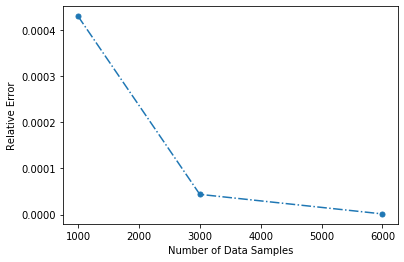

In [14]:
data = success_rate_df[success_rate_df['p'] == 5]
data = data[data['var_L'] == 1]
y = data['error']
x = data['m']
print('Relative error with respect to number of data samples for the convex solution.')
plt.plot(x,y, linestyle = '-.', marker='o',markersize=5)

plt.xlabel('Number of Data Samples')
plt.ylabel('Relative Error')

Relative error with respect to the initialization variance of L* for the convex solution.


Text(0, 0.5, 'Relative Error')

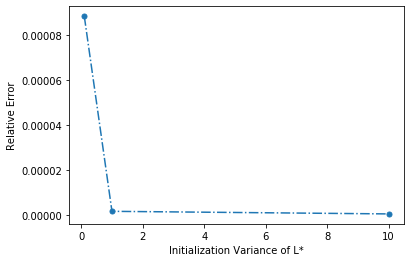

In [16]:
data = success_rate_df[success_rate_df['p'] == 5]
data = data[data['m'] == 6000]
y = data['error']
x = data['var_L']
print('Relative error with respect to the initialization variance of L* for the convex solution.')
plt.plot(x,y, linestyle = '-.', marker='o',markersize=5)

plt.xlabel('Initialization Variance of L*')
plt.ylabel('Relative Error')

Relative error with respect to parameter p for the convex solution.


Text(0, 0.5, 'Relative Error')

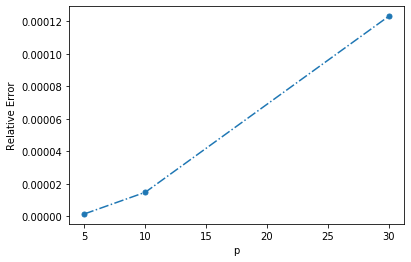

In [17]:
data = success_rate_df[success_rate_df['var_L'] == 1]
data = data[data['m'] == 6000]
y = data['error']
x = data['p']
print('Relative error with respect to parameter p for the convex solution.')
plt.plot(x,y, linestyle = '-.', marker='o',markersize=5)

plt.xlabel('p')
plt.ylabel('Relative Error')

##### Try different sizes of data sets. 

In [91]:
K = 20
p = 10
all_m = [1000, 3000, 6000, 8000]

mean = np.zeros(p)
cov = np.identity(p)
for m in all_m:
    x = np.array(np.random.multivariate_normal(mean,cov,m))
    x = x.reshape(x.shape[0], x.shape[1], 1)
    L_star = create_L_star(p,r)
    y = np.array(create_y(x, L_star))
    y = y.reshape(y.shape[0], 1, 1)
    y = y.reshape(y.shape[0], 1)
    L_hat = solveConvexProblem(offset, x, y, p)
    L_hat_norm = la.norm(L_hat, ord = 2)
    L_star_norm = la.norm(L_star, ord = 2)
    rel_err = np.abs((L_star_norm - L_hat_norm)/L_star_norm)
    print('m:', m, 'error:', rel_err, 'Error < 0.05?', rel_err < 0.05)

m: 1000 error: 1.0134299507699404e-07 Error < 0.05? True
m: 3000 error: 1.1044371014841167e-07 Error < 0.05? True
m: 6000 error: 5.32094459738086e-08 Error < 0.05? True
m: 8000 error: 2.31939202341918e-08 Error < 0.05? True


##### How accurate is the convex relaxation for this problem? How sensitive is it to the size of data set and noise?

In [93]:
all_m = [1000, 8000]
p = 10
r = 5
var = 1
noise_levels = [0.0001, 0.1, 1, 10, 100]
mean = np.zeros(p)
cov = np.identity(p)

for m in all_m:
    x = np.array(np.random.multivariate_normal(mean,cov,m))
    x = x.reshape(x.shape[0], x.shape[1], 1)
    L_star = create_L_star(p,r)
    test_symmetry(L_star)
    y = create_y(x, L_star)
    y = y.reshape(y.shape[0], 1, 1)
    y = y.reshape(y.shape[0], 1)
    for noise_level in noise_levels:
        noise = np.random.normal(0, noise_level,(m, p))
        noise = noise.reshape(noise.shape[0], noise.shape[1], 1)
        x_noise = x + noise
        L_hat = solveConvexProblem(offset, x_noise, y, p) 
        L_hat_norm = la.norm(L_hat, ord = 2)
        L_star_norm = la.norm(L_star, ord = 2)
        rel_err = relative_error(L_star_norm, L_hat_norm)
        print('m:', m, 'noise level:', noise_level, 'err:', rel_err, 'Successful recovery?', rel_err < 0.05)

m: 1000 noise level: 0.0001 err: 1.0549253875046242e-05 Successful recovery? True
m: 1000 noise level: 0.1 err: 0.008824625676521447 Successful recovery? True
m: 1000 noise level: 1 err: 0.6997157421784946 Successful recovery? False
m: 1000 noise level: 10 err: 0.9961500755783373 Successful recovery? False
m: 1000 noise level: 100 err: 0.9999621374087171 Successful recovery? False
m: 8000 noise level: 0.0001 err: 3.43276404015375e-06 Successful recovery? True
m: 8000 noise level: 0.1 err: 0.02050920786604547 Successful recovery? True
m: 8000 noise level: 1 err: 0.6957260118396038 Successful recovery? False
m: 8000 noise level: 10 err: 0.9975999837325976 Successful recovery? False
m: 8000 noise level: 100 err: 0.9999762167724802 Successful recovery? False


We can see that the algorithm is also able to reconstruct the weights, even with fewer data samples. The error for the convex solution is for a dataset with 1000 samples in the 10^-8 range. We can also see that the convex solution is also able to reconstruct $L_*$ for $x$ initialized with normally distributed datasamples with a different mean than zero and a covariance different than the identity. I also note that training the convex solution takes significantly longer than training the iterative solution. I had to run the parameter comparison above for 3 hours and the iterative solution above only took a couple of minutes, even though above I used monte carlo trials, which I did not use for the convex approach.

The size of the dataset does not seem to matter a lot. The error does not necessarily decrease with the bigger data sets, but it is low enough from the beginning to successfully recover the ground truth matrix $L_*$. 

In comparison to the non convex solution, the convex approach seems to be not very sensitive to different parameters $p$, data sizes $m$ and initialization variances for the ground truth weights in $L_*$. It also seems to not be sensitive towards the initial distribution of the training data, so initialisation mean and covariance can differ and the convex solution is still able to sufficiently reconstruct the ground truth weight matrix $L_*$.

The convex relaxation is similarly sensitive to noise as the iterative algorithm, so it can successfully reconstruct noise levels lower than 1. It seems to not be very sensitive if the training dataset is small. We can however see that the error doesn't explode like for the iterative approach.

All in all I would say that the convex approach is sufficiently accurate, even though its accuracy is lower than for the iterative non convex approach. The advantage of the convex approach is the robustness towards training data distribution and no need for many fresh data samples for training, however even with small dataset training takes quite a while.The disadvantage is the long training time. 

##### Generate a new data set where each xi can come from two different Gaussian distributions (representing two classes) with two different means (you can keep the covariance same if you wish). Assign each data point  a  binary  label  based  on  its  class.  (Note  that  there  is  no  ground  truth  network  in  this  case).  

In [31]:
m = 3000
p = 10
r = 5
K = 20

mean = np.zeros(p)
cov = np.identity(p)
x1 = np.array(np.random.multivariate_normal(mean,cov,int(K*m/2)))

mean = np.ones(p)
cov = np.identity(p)
x2 = np.array(np.random.multivariate_normal(mean,cov,int(K*m/2)))

y1 = np.zeros(int(K*m/2))
y2 = np.ones(int(K*m/2))
x_train = np.concatenate((x1, x2), axis=0)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

y_train = np.concatenate((y1, y2), axis=0)
y_train = y_train.reshape(y_train.shape[0], 1, 1)

##### Run the two algorithms that you have implemented in the last two parts (non-convex and convex) to train the polynomial neural network (which is also equivalent to learning a matrix L). 

In [32]:
L_hat_non_convex = EP_ROM(y_train, K, x_train, r, p)  

In [33]:
offset = 1
y_train = y_train.reshape(y_train.shape[0], 1)
L_hat_convex = solveConvexProblem(offset, x_train, y_train, p)

##### Generate some new test data points  from  your  classes  and  evaluate  the  performance  of  the  learned  network  on  the  test  dataset.  Are these algorithms able to classify the data? If not, why? Try to justify.

In [35]:
m = 400
mean = np.zeros(p)
cov = np.identity(p)
x1 = np.array(np.random.multivariate_normal(mean,cov,int(K*m/2)))

mean = np.ones(p)
cov = np.identity(p)
x2 = np.array(np.random.multivariate_normal(mean,cov,int(K*m/2)))

y1 = np.zeros(int(K*m/2))
y2 = np.ones(int(K*m/2))

x_test = np.concatenate((x1, x2), axis=0)
y_test = np.concatenate((y1, y2), axis=0)
y_test = y_test.reshape(y_test.shape[0], 1)

y_pred_convex = A(L_hat_convex,x_test)
y_pred_non_convex = A(L_hat_non_convex,x_test)

y_pred_convex_to_closest_label = np.array(list(map(lambda x: 0 if abs(1-x) > abs(0-x) else 1, y_pred_convex)))
y_pred_non_convex_to_closest_label = np.array(list(map(lambda x: 0 if abs(1-x) > abs(0-x) else 1, y_pred_non_convex)))

rmse_convex = mean_squared_error(y_test, y_pred_convex)
rmse_non_convex = mean_squared_error(y_test, y_pred_non_convex)
print('RMSE convex problem:', rmse_convex, 'RMSE non convex problem:', rmse_non_convex)

rmse_convex_to_closest_label = mean_squared_error(y_test, y_pred_convex_to_closest_label)
rmse_non_convex_to_closest_label = mean_squared_error(y_test, y_pred_non_convex_to_closest_label)
print('RMSE match to closest label convex problem :', rmse_convex_to_closest_label, 'non convex problem:', rmse_non_convex_to_closest_label)


RMSE convex problem: 0.1205901696980856 RMSE non convex problem: 1.4027387732468592e+40
RMSE match to closest label convex problem : 0.140375 non convex problem: 0.498875


We can see that the convex solution performs reasonably well with a RMSE of 0.12 for classifying the data from the two classes. This makes sense because the convex solution does not make any assumptions on the data generation of $y$ and is thus able to generalise better. However, the non-convex iterative solution does not scale at all. This makes sense because our data does not comply with the assumptions made by the authors in [1]. The labels in $y$ are not generated by $x^TL_*x$ but rather randomly assigned as 0 and 1. This breaks the performance of the algorithm.

If I however match the predictions to the closest possible label, the prediction error of the non convex problem decreases to 0.5.

#### BONUS
##### If  you  were  able  to  solve  a  binary  classification  problem  on  the  random  data  set  in  previous question, try to apply your algorithm on the MNIST dataset (You can restrict your dataset to only 0 and 1 digits). Is there any way to extend this idea for multi-class classification? How?

In [36]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()    

In [37]:
flattened_dim = X_train.shape[2]*X_train.shape[2]
pca = PCA(n_components=30)
X_train_cvx = X_train.reshape(X_train.shape[0], flattened_dim)
X_train_convex = pca.fit_transform(X_train_cvx)

X_test_cvx = X_test.reshape(X_test.shape[0], flattened_dim)
X_test_convex = pca.fit_transform(X_test_cvx)

flattened_dim = X_train.shape[1]*X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], flattened_dim, 1)
X_train = X_train == 0
Y_train = Y_train.reshape(Y_train.shape[0],1, 1)

X_test = X_test.reshape(X_test.shape[0], flattened_dim)
print(X_train.shape, Y_train.shape)
print(X_train_convex.shape)

(60000, 784, 1) (60000, 1, 1)
(60000, 30)


In [38]:
K = 20
r = 5
L_hat_non_convex = EP_ROM(Y_train, K, X_train, r, flattened_dim) 

In [39]:
y_pred_non_convex = A(L_hat_non_convex,X_test)
rmse_non_convex = mean_squared_error(Y_test, y_pred_non_convex)
print('RMSE non convex problem:', rmse_non_convex)

RMSE non convex problem: 2.3332431552150854e+225


In [40]:
offset = 1
X_train_convex = X_train_convex.reshape(X_train_convex.shape[0], X_train_convex.shape[1], 1)
Y_train = Y_train.reshape(Y_train.shape[0],1)
L_hat_convex = solveConvexProblem(offset, X_train_convex, Y_train, X_train_convex.shape[1])

In [41]:
y_pred_convex = A(L_hat_convex,X_test_convex)
rmse_convex = mean_squared_error(Y_test, y_pred_convex)
print('RMSE convex problem:', rmse_convex)

RMSE convex problem: 13.605751483166323


In [43]:
y_pred_convex_to_closest_label = np.array(list(map(lambda x: 0 if abs(1-x) > abs(0-x) else 1, y_pred_convex)))
rmse_convex_to_closest_label = mean_squared_error(Y_test, y_pred_convex_to_closest_label)
print('RMSE match to closest label convex problem :', rmse_convex_to_closest_label)

RMSE match to closest label convex problem : 20.4131


In [44]:
y_pred_non_convex_to_closest_label = np.array(list(map(lambda x: 0 if abs(1-x) > abs(0-x) else 1, y_pred_non_convex)))
rmse_non_convex_to_closest_label = mean_squared_error(Y_test, y_pred_non_convex_to_closest_label)
print('RMSE match to closest label non convex problem:', rmse_non_convex_to_closest_label)

RMSE match to closest label non convex problem: 20.2422


As expected, the iterative non-convex algorithm was not able to classify the test data correctly, since the training data does not underly the expected structure and thus no accurate approximation of $L_*$ could be learned. 
For the convex approach, the high dimensionality of the data of 28*28 forced me to decrease the training dimension using Principal Component Analysis to be able to run the solution. Previous results indicated that the convex approach could be run with dimension 30 without the kernel dying. I am sure with higher computational power, and training the on the whole training dataset will increase robustness of the classification of the convex approach.
As expected with such a high dimensionality reduction, the results are not very good. The RMSE is around 13.6 and if I assign the prediction to the closest label it is even hight at 20.41.

I think this idea could be extended to multi class classification. One way is to use multiple binary classifiers. Otherwise I think we could also do a regression and then classify the results to the nearest class label.

##### Discussion: This section will provide a critical discussion of your results, and evaluate the strengths and weaknesses of different algorithms and the associated trade-offs

To summarize the findings I commented within the code, there are many advantages as well as limitations with the convex and non convex methods evaluated in this project. First of all, the authors of [1] did an amazing job using a low rank estimation problem for a highly relevant field of provable learning. Their algorithm is understandable when doing some background research on low rank matrix estimation. Their algorithm is very fast, but requires a comparatively big dataset to start with. In this project, 20 batches of 3000 samples lead to good results. The algorithm is based on a specific structure of input data and relation of input data to the labels which the neural network needs to learn. This limits the applicability of the algorithm to real world data. It is dependent on the initialization of the data to be zero mean and identity covariance. Zero mean can be normalized to, but we almost never have identity covariance for the features (or dimensions) of the training data. Also, many problems do not have a clear data to label relationship ($x^TL_*x$). Thus, this algorithm is great for showing that provable learning is possible, but is highly limited to real world with very specific underlying data structures. If those data structures are met, the non convex iterative algorithm produces highly accurate reconstructions of the ground truth matrix and very fast computational efficiency for training.

On the other hand, the convex relaxation of this project turned out to be sufficiently accurate to reconstruct the ground truth matrix $L_*$, even with few data samples to begin with. However, solving the convex problem was not computationally efficient, especially for numerous training samples or high dimensions. However, the convex approach was able to handle data samples which came from a normal distribution with random mean and covariance and can thus be used for a broader set of problems. It also did a better job learning the binary problem and did not suffer from error explosion for different initializations and data dimensions. 


#### References:
1)  Soltani, Mohammadreza, and Chinmay Hegde. “Towards provable learning of polynomial neural networksusing low-rank matrix estimation”.International Conference on Artificial Intelligence and Statistics. 2018.

2)  Candès,  Emmanuel  J.,  and  Yaniv  Plan.  “Tight  oracle  inequalities  for  low-rank  matrix  recovery  from  aminimal  number  of  noisy  random  measurements.”IEEE  Transactions  on  Information  Theory57.4  (2011):2342-2359.

3)  Recht, B., Fazel, M. and Parrilo, P.A., 2010. “Guaranteed minimum-rank solutions of linear matrix equationsvia nuclear norm minimization”.SIAM review, 52(3), pp.471-501.

4)  Goldstein, Tom, Christoph Studer, and Richard Baraniuk. “FASTA: A generalized implementation of forward-backward splitting.”arXiv preprint arXiv:1501.04979 (2015).

5) E. J. Candès, X. Li, Y. Ma, and J. Wright, Robust Principal
Component Analysis? Stanford Univ., Stanford, CA, 2009 [Online]. Available: http://statistics.stanford.edu/~ckirby/techreports/
GEN/2009/2009-13.pd

6)  D. Gross, Y. Liu, S. Flammia, S. Becker, and J. Eisert, Quantum State
Tomography via Compressed Sensing, 2009 [Online]. Available: http://
arxiv.org/PS_cache/arxiv/pdf/0909/ 0909.3304v2.pdf

7) R. Basri and D. Jacobs, “Lambertian reflectance and linear subspaces,”
IEEE Trans. Pattern Anal.Mach. Intell., vol. 25, no. 2, pp. 218–233, Feb.
2003

8) MNIST Dataset. Shown in Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998. Download at: http://yann.lecun.com/exdb/mnist/

9) Fazel, M. Matrix rank minimization with applications. PhD thesis, PhD thesis, Stanford University, 2002.

10) Candès, E. and Recht, B. Exact matrix completion via convex optimization. Found. Comput. Math., 9(6), 2009.

11) L. El Ghaoui and P. Gahinet, Rank minimization under LMI constraints: A framework for output feedback problems, in Proceedings of the 2nd European Control Conference, 1993, pp. 1176–1179.

12) M. Fazel, H. Hindi, and S. Boyd, A rank minimization heuristic with application to minimum order system approximation, in Proceedings of the American Control Conference, IEEE, 2001, pp. 4734–4739

#### BONUS

##### Authors in [1] have compared their algorithms with a convex solver proposed in [4] (FASTA). Read this paper and implement this algorithm. Apply FASTA on your generated data set and compare the results with previous parts.

In [48]:
m = 3000
p = 10
r = 5
K = 20

mean = np.zeros(p)
cov = np.identity(p)
x1 = np.array(np.random.multivariate_normal(mean,cov,int(K*m/2)))

mean = np.ones(p)
cov = np.identity(p)
x2 = np.array(np.random.multivariate_normal(mean,cov,int(K*m/2)))

y1 = np.zeros(int(K*m/2))
y2 = np.ones(int(K*m/2))
x_train = np.concatenate((x1, x2), axis=0)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

y_train = np.concatenate((y1, y2), axis=0)
y_train = y_train.reshape(y_train.shape[0], 1, 1)
m = 400
mean = np.zeros(p)
cov = np.identity(p)
x1 = np.array(np.random.multivariate_normal(mean,cov,int(K*m/2)))

mean = np.ones(p)
cov = np.identity(p)
x2 = np.array(np.random.multivariate_normal(mean,cov,int(K*m/2)))

y1 = np.zeros(int(K*m/2))
y2 = np.ones(int(K*m/2))

x_test = np.concatenate((x1, x2), axis=0)
y_test = np.concatenate((y1, y2), axis=0)
y_test = y_test.reshape(y_test.shape[0], 1)
def A_cvx_err_fasta(L,x, y):
    x = x.reshape(x.shape[0], x.shape[1], 1)
    x = np.array(x)
    A_Lt = []
    assert(L.shape == (x.shape[1], x.shape[1]) and L[0,0].shape == ())
    A_Lt = list(map(lambda x_i: cp.quad_form(x_i, L), x))
    A_Lt =  A_Lt.reshape(A_Lt.shape[0], 1)
    A_Lt = np.array(A_Lt)
    error = y - A_Lt
    error = error.reshape(error.shape[0], )
    adjoint_value = np.zeros((x.shape[1], x.shape[1]))
    for i in range(0, x.shape[0]):
        x_i = x[i]
        e_i = e[i]
        x_i = np.array(x_i)
        x_i = x_i.reshape(x_i.shape[0], 1)
        xxt = np.dot(x_i, x_i.T)
        exxt = cp.multiply(e_i, xxt)
        adjoint_value = np.sum([adjoint_value, exxt], axis=0)
    a_st_x_e = adjoint_value
    return a_st_x_e

L = np.zeros((p,p))
f = lambda L: la.norm(L, 'nuc') # objective
g = lambda x: 0
gradf = lambda x: 1
prox = lambda L, x, y: la.norm(A_cvx_err_fasta(L,x, y), 2) <= lmbd(np.sqrt(var))
A = 1
At = 1

L = np.zeros((p,p))
f = lambda L: la.norm(L, 'nuc') # objective
g = lambda x: 0
gradf = lambda x: 1
prox = lambda L, x, y: la.norm(A_cvx_err_fasta(L,x, y), 2) <= lmbd(np.sqrt(var))
A = 1
At = 1
eng = matlab.engine.start_matlab()
eng.fasta(A, At, f, gradf, g, prox, L )
eng.quit()